In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.datasets import mnist #fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

In [246]:
1./28

0.03571428571428571

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
def one_hot(a, c=10):
    b = np.zeros((a.size, c))
    b[np.arange(a.size),a] = 1
    return b

one_hot_targets=True

if one_hot_targets:
    y_train=one_hot(y_train)
    y_test=one_hot(y_test)

(np.min(X_test), np.max(X_test))


X_train = X_train.reshape(-1, 28, 28, 1)/255 - 0.5
X_test = X_test.reshape(-1, 28, 28, 1)/255 -0.5
(np.min(X_test), np.max(X_test))


(-0.5, 0.5)

Randomly selected image: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


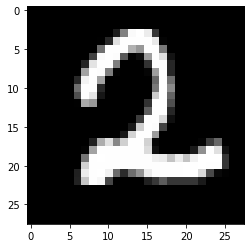

In [3]:
rand_idx = np.random.randint(X_train.shape[0])
rand_img = X_train[rand_idx]
print('Randomly selected image:', y_train[rand_idx])
plt.imshow(rand_img, cmap='gray');

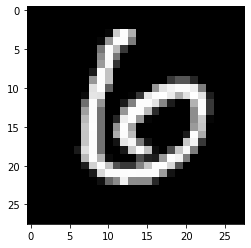

In [4]:
X_t=X_test.reshape(-1,28*28)
X_t_s=[X_t[np.argmax(y_test, axis=1)==i] for i in range(10)]


plt.imshow(X_t_s[6][0].reshape(28,28), cmap='gray');
#np.argmax(y_test, axis=1)==0

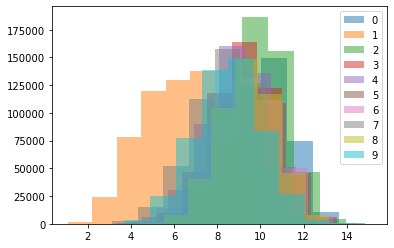

In [5]:
from scipy.spatial.distance import pdist, cdist
from itertools import combinations

classes=range(10)#[5,6]

cdists=[((i,j),cdist(X_t_s[i],X_t_s[j])) for i,j in combinations(classes, 2)]
cdists_=[(i,pdist(X_t_s[i])) for i in classes]

for l, dists in cdists_:
    plt.hist((dists.reshape(-1)), label=str(l), alpha=0.5)
plt.legend()

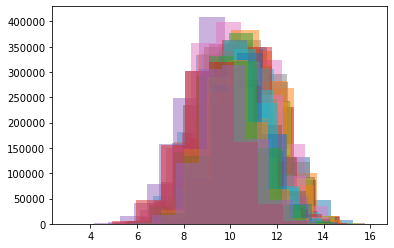

In [6]:
for l, dists in cdists:
    plt.hist((dists.reshape(-1)), label=str(l), alpha=0.5)


We use a predictor $f:\mathcal{X}\to [0,1]^c$ where $\mathcal{C}$ is the input space ($[0,1]^{784}$ as $28^2=784$ and using pixel normalisation $[0,255]\mapsto [0,1]$) and $c$ is the number of classes. Each class is $i<c$ is encoded as a vector $t_i\in [0,1]^c$ defined by $t^i_i=1$ and $t^i_j=0$ if $i\neq j$. 


The prediction of the class on input $X$ is given by $\hat{f}(X)=\textrm{argmax}_{i<c} f(X)$. In particular $\textrm{argmax}_{i<c} t^j=j$ for all $j<c$.

We use the Euclidean distance on both the input space and the output space. The diameter of the input space is $||(1,1,1,\ldots,1)||=\sqrt{784}=28$ and $\sqrt{c}\approx 3.16$ for the output space. Whenever $i<j<c$ we have $||t^i-t^j||=\sqrt{2}$. 

Note that for every $t\in [0,1]^c$, if $||t^j-t||<\frac{\sqrt{2}}{2}$ then $\textrm{argmax}_{i<c} t=j$.

> Proof: Suppose that $\textrm{argmax}_{i<c} t=i\neq j$. Then in particular $t_i> t_j$ and so $||t^j-t||^2\geq (1-t_j)^2+ t_i^2>  (1-t_i)^2+ t_i^2 \geq \frac{1}{2}$. Therefore $||t^j-t||\geq \frac{\sqrt{2}}{2}$. The results follows by contraposition.

Let $\epsilon\leq \frac{\sqrt{2}}{2}$. Suppose that $f$ is $k$-Lipschitz with $k\leq \frac{\sqrt{2}}{2\epsilon}$. Let $f(X)=t^i$ for some $i<c$ ($X$ is perfectly classified by $f$). Then for every $h\in \mathcal{X}$ with $||h||\leq \epsilon$ we have $\hat{f}(X+h)=i=\hat{f}(X)$.
> Proof: Let $||h||\leq \epsilon$. Since $f$ is $k$-Lipschitz we have: 
$$
||t^j-f(X+h)||=||f(X)-f(X+h)||\leq k ||X-(X+h)||\leq k ||h||\leq k\epsilon < \frac{\sqrt{2}}{2}
$$
By the previous note, this implies that $\hat{f}(X+h)=j$ as desired.

For example with $\epsilon=.7$ we can take $k=\frac{\sqrt{2}}{2*0.7}\approx 1.01$.

In [117]:
epsilon=.7
k_coef_lip=np.sqrt(2)/(2*epsilon)
print(k_coef_lip)

K=[0.5, 1., 2., 3., 5.] #add 10., 50. 100. 
EPSILON=[1/(k*np.sqrt(2)) for k in K]
print(K)
print(EPSILON)
EPSILON_=[e/28 for e in EPSILON]
print(EPSILON_)
0.2*28, 28, 0.2*28*.5, np.sqrt(784*0.2**2)

1.0101525445522108
[0.5, 1.0, 2.0, 3.0, 5.0]
[1.414213562373095, 0.7071067811865475, 0.35355339059327373, 0.2357022603955158, 0.1414213562373095]
[0.050507627227610534, 0.025253813613805267, 0.012626906806902633, 0.008417937871268422, 0.005050762722761054]


(5.6000000000000005, 28, 2.8000000000000003, 5.6000000000000005)

In [118]:
loss='categorical_crossentropy'#
#loss='mean_squared_error'

In [143]:
from deel.lip.layers import SpectralDense, SpectralConv2D, ScaledL2NormPooling2D
from deel.lip.activations import GroupSort
from keras.layers import  Input, MaxPooling2D, Flatten, Dropout, Conv2D, Dense 

loss='categorical_crossentropy'#


def Lip_Model(k):
    from deel.lip.model import Sequential
    model = Sequential(
        [
          Input(shape=(28, 28, 1)),
          SpectralConv2D(16, (3,3), activation='relu'),
          MaxPooling2D(2, 2),
          SpectralConv2D(32, (3,3), activation='relu'),
          MaxPooling2D(2, 2),
          SpectralConv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2, 2),
          Flatten(),
          SpectralDense(128, activation='relu'),
          #Dropout(0.25),
          SpectralDense(10, activation='softmax')      
        ],
        k_coef_lip=k
    )
    model.compile(loss=loss, optimizer='Adam', metrics=['acc'])
    return model

def Model():
    from keras import Sequential
    model = Sequential(
    [
      Input(shape=(28, 28, 1)),
      #x = Lambda(svd_truncate)(i)   # This is the SVD layer
      Conv2D(16, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Conv2D(32, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      SpectralConv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2, 2),
      Flatten(),
      Dense(128, activation='relu'),
      #Dropout(0.25),
      Dense(10, activation='softmax')      
    ])

    model.compile(loss=loss, optimizer='Adam', metrics=['acc'])

    return model

model_dict={'standard':Model()}
model_dict.update({'Lip {}'.format(k): Lip_Model(k) for k in K})

for l,m in model_dict.items():
    print(l)
    print(m.summary())

/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: max_pooling2d_44
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: max_pooling2d_45
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: max_pooling2d_46
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: flatten_19
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: max_pooling2d_47
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning:

standard
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
spectral_conv2d_35 (Spectral (None, 5, 5, 64)          18561     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 256)    

/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: max_pooling2d_56
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: max_pooling2d_57
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: max_pooling2d_58
  warn(
/home/yann/anaconda3/envs/tf/lib/python3.8/site-packages/deel/lip/model.py:54: UserWarning: Sequential model contains a layer wich is not a Lipschitsz layer: flatten_23
  warn(


(-0.05, 1.05)

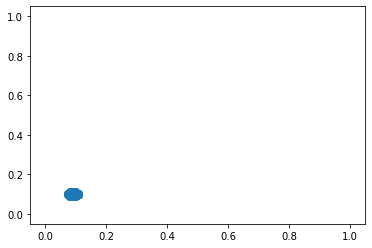

In [8]:
pred=model_dict['standard'].predict(X_test.reshape(-1, 28, 28, 1))
i,j=1,7

plt.scatter(pred[:,i],pred[:,j])
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)

In [91]:
model_dict['Lip 3.0'](X_test).shape, y_test.shape



(TensorShape([10000, 10]), (10000, 10))

In [144]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5



In [189]:
for model in model_dict.values():
    model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0222 - acc: 0.9931 - val_loss: 0.0390 - val_acc: 0.9882
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0193 - acc: 0.9937 - val_loss: 0.0339 - val_acc: 0.9890
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0163 - acc: 0.9947 - val_loss: 0.0343 - val_acc: 0.9892
Epoch 4/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0129 - acc: 0.9960 - val_loss: 0.0334 - val_acc: 0.9903
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0126 - acc: 0.9957 - val_loss: 0.0382 - val_acc: 0.9879
Epoch 6/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0098 - acc: 0.9966 - val_loss: 0.0427 - val_acc: 0.9890
Epoch 7/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0106 - acc: 0.9963 - val_loss: 0.0291 - val_acc: 0.9912
Epoch 8/10
938/938 [==============================] - 9s 10ms/step - 

In [249]:
ACC_dict={}

In [252]:
ACC={}
for l,m in model_dict.items():
    ACC.update({l:m.evaluate(X_test, y_test)[1]})

ACC_dict.update({'Test':ACC})

313/313 [==============================] - 2s 8ms/step - loss: 0.3431 - acc: 0.9606


In [253]:
# Generate FGSM examples

def fgsm_pattern(model, image, labels):
    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(labels, prediction)

    gradient = tape.gradient(loss, image)

    signed_grad = tf.sign(gradient)

    return signed_grad

def fgsm_example(model, X, y, n_class, eps=0.1):
    perturbations = fgsm_pattern(model, X, y)
    adversarial = X + perturbations * eps
    return np.clip(adversarial, -.5, .5)

In [256]:
# FGSM attack

FGSM_eps=[0.05,.1,.2,.3]
for eps in FGSM_eps:
    ACC={}
    for l,m in model_dict.items():
        if not l=='standard':
            m=m.vanilla_export()
            m.compile(loss=loss, optimizer='Adam', metrics=['acc'])

        adversarial = fgsm_example(m, X_test, y_test, 10, eps)
        ACC.update({l:m.evaluate(adversarial, y_test)[1]})
    ACC_dict.update({'FGSM {}'.format(eps):ACC})

313/313 [==============================] - 1s 3ms/step - loss: 2.0610 - acc: 0.2076


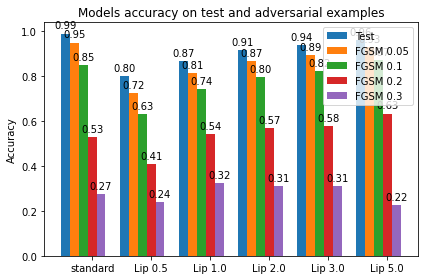

In [194]:

def plot(acc):
    labels = acc['Test'].keys()
    
    x = np.arange(len(labels))  # the label locations
    width = 0.9/len(acc['Test'].keys())  # the width of the bars

    
    
    fig, ax = plt.subplots()
    rects=[]
    
    i=0.
    for l,d in acc.items(): 
        x_=x-0.45 + i*width
        rects.append(ax.bar(x_, d.values(), width, label=l))
        i+=1.

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_title('Models accuracy on test and adversarial examples')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    for rect in rects:
        autolabel(rect)

    fig.tight_layout()
    return fig
fig=plot(ACC_dict)

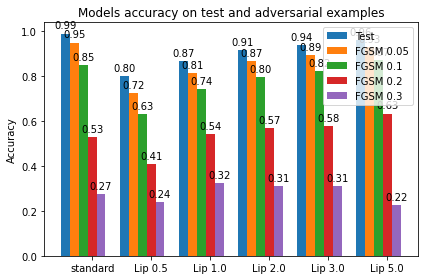

In [257]:
fig=plot(ACC_dict)

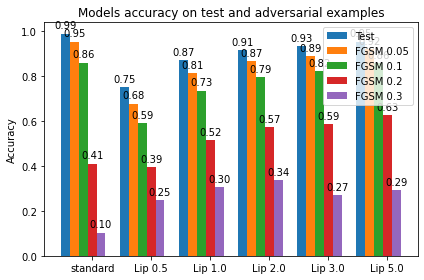

In [151]:
fig=plot(ACC_dict)

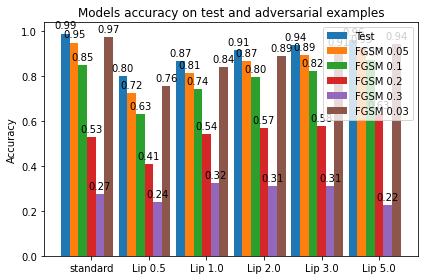

In [248]:
fig=plot(ACC_dict)

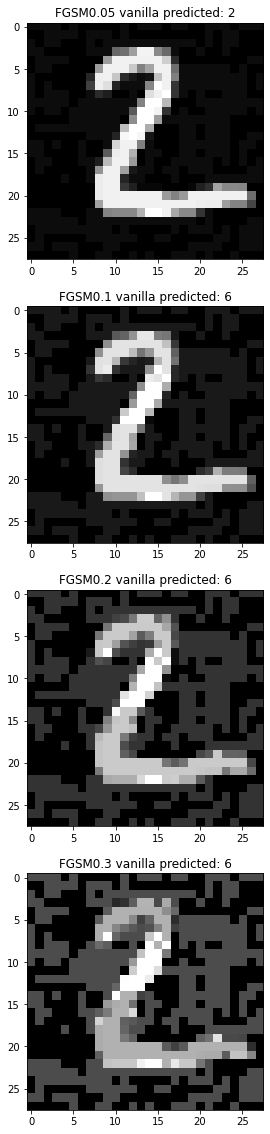

In [196]:
fig, ax=plt.subplots(len(FGSM_eps), figsize=(5,20))
i=0
model=model_dict['Lip 1.0']
for eps in FGSM_eps:
    adversarial = fgsm_example(model, X_test, y_test, 10, eps)

    rand_idx = 1
    ax[i].imshow(adversarial[rand_idx].reshape(28, 28), cmap='gray');
    predicted = np.argmax(model.predict(adversarial[rand_idx].reshape(-1, 28, 28, 1)))
    ax[i].set_title('FGSM'+str(eps)+' vanilla predicted: '+str(predicted))
    i+=1

Predicted value: 8
True value: 8
Input image


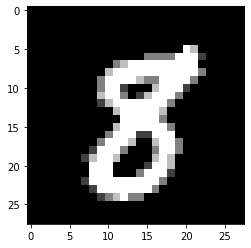

In [49]:
rand_test_idx = np.random.randint(X_test.shape[0])
rand_test_img = X_test[rand_test_idx]
plt.imshow(rand_test_img.reshape(28,28), cmap='gray');

predicted = model.predict(rand_test_img.reshape(-1, 28, 28, 1))
print('Predicted value:', np.argmax(predicted))
print('True value:', np.argmax(y_test[rand_test_idx]))
print('Input image')

In [231]:
inputs=X_test
epsilon_=.2
print(epsilon_)

model=model_dict['Lip 5.0']


output=model.predict(inputs.reshape(-1, 28, 28, 1))
inputs_=inputs+epsilon_ * np.sign(np.random.normal(size=inputs.shape))#epsilon*tf.ones(inputs,  dtype='float')
output_=model.predict(inputs_.reshape(-1, 28, 28, 1))


0.2


In [232]:
(output-y_test).shape, np.mean(np.sqrt(np.sum(np.square(output-y_test), axis=1)))

((10000, 10), 0.27912888087748067)

In [233]:
correct_indices=(np.argmax(output, axis=1)==np.argmax(y_test, axis=1))
np.sum(correct_indices)/len(output)

0.9606

In [234]:
output_correct=output[correct_indices]
output_correct_=output_[correct_indices]
y_test_correct=y_test[correct_indices]

In [235]:
np.sum((np.argmax(output, axis=1)==np.argmax(output_, axis=1)))/len(output)

0.9546

In [236]:
np.sum((np.argmax(output_correct, axis=1)==np.argmax(output_correct_, axis=1)))/len(output)

0.9289

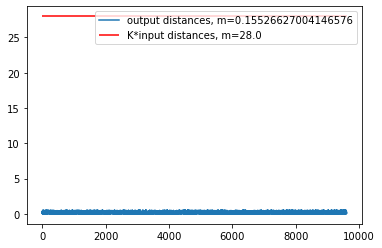

In [237]:
if k_coef_lip is None:
    k_coef_lip=1.
dist=5.0*np.linalg.norm((inputs[0]-inputs_[0]).reshape(-1,28*28),axis=1)
plt.hlines(dist, 0, len(output_correct), label='K*input distances, m={}'.format(np.mean(dist)), color='red')
dist=np.linalg.norm(output_correct-output_correct_, axis=1)
plt.plot(range(len(output_correct)),dist, label='output distances, m={}'.format(np.mean(dist)))
plt.legend()

In [238]:
5.6*5

28.0

Text(0.5, 1.0, 'predicted:7')

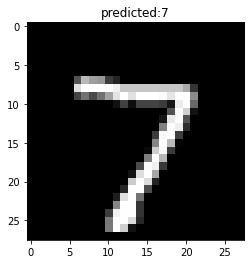

In [239]:
plt.imshow(inputs[0].reshape(28,28), cmap='gray');
plt.title('predicted:{}'.format(np.argmax(output[0])))

Text(0.5, 1.0, 'predicted:7')

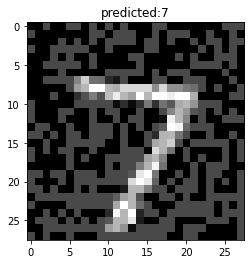

In [240]:
plt.imshow(inputs_[0].reshape(28,28), cmap='gray');
plt.title('predicted:{}'.format(np.argmax(output_[0])))

In [241]:
np.linalg.norm(output[0]-output_[0])

0.086775795

In [242]:
np.linalg.norm(y_test[0]-y_test[1])

1.4142135623730951

In [243]:
from scipy.spatial.distance import pdist, cdist
from itertools import combinations
import seaborn as sns
classes=range(10)#[5,6]

pred_t_s=[output[np.argmax(y_test, axis=1)==i] for i in classes]
y_test_s=[y_test[np.argmax(y_test, axis=1)==i] for i in classes]


cdists_=[(i,cdist(pred_t_s[i], one_hot(np.array([i])))) for i in classes]



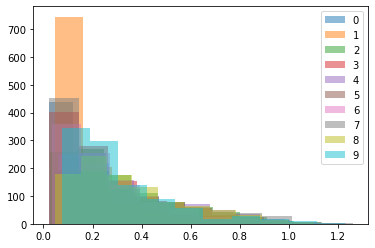

In [244]:
for l, dists in cdists_:
    plt.hist(dists, label=str(l), alpha=0.5)
plt.legend()

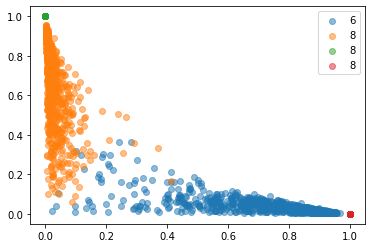

In [245]:
i=6
j=8
plt.scatter(pred_t_s[i][:,i],pred_t_s[i][:,j], label=i, alpha=.5)
plt.scatter(pred_t_s[j][:,i],pred_t_s[j][:,j], label=j,alpha=.5)
plt.scatter(y_test_s[j][:,i],y_test_s[j][:,j], label=j,alpha=.5)
plt.scatter(y_test_s[i][:,i],y_test_s[i][:,j], label=j,alpha=.5)

# plt.scatter(eps,1-eps, marker='x',color='red', lw=5.)
# plt.scatter(1-eps,eps, marker='x',color='red', lw=5.)

#plt.xlim(0,1)
#plt.ylim(0,1)
plt.legend()

In [167]:
cdists=[((i,j),cdist(pred_t_s[i],pred_t_s[j])) for i,j in combinations(classes, 2)]




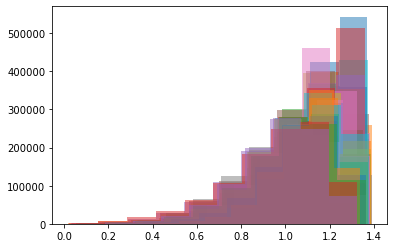

In [207]:
for l, dists in cdists:
    plt.hist(dists.reshape(-1), label=str(l), alpha=0.5)